# **Projet : Recherche d'images patrimoniales par le contenu (CBIR) via CLIP (Inférence CLIP Zero-Shot (Base))**
**Thème**: Apprentissage de représentations multimodales pour la recherche de « near-duplicates » dans des fonds photographiques historiques (Collections Branger et Harlingue).

# **Étape 1 : Préparation de l'environnement et structuration des données**


Dans cette partie, l'objectif est de centraliser les ressources (images et métadonnées) et de créer une structure de données exploitable pour l'algorithme de recherche.

**1.1. Montage du Google Drive**

Cette étape permet d'accéder aux fichiers images et aux inventaires Excel stockés sur votre Drive.

In [1]:
from google.colab import drive
import os
import pandas as pd
from PIL import Image

drive.mount('/content/drive')

Mounted at /content/drive


**1.2. Fusion et nettoyage des métadonnées(Fichiers Excel)**

Le projet s'appuie sur deux collections distinctes. Nous lisons les fichiers Excel d'inventaire, extrayons les colonnes critiques (photoref pour l'identifiant et LEGENDE_FR pour le contexte textuel) et les fusionnons dans un DataFrame unique de plus de 52 000 entrées.

In [2]:
# Chemins vers les fichiers Excel
path_branger = "/content/drive/MyDrive/Projet_CLIP/data/output_folder_Branger/BHVP_CollRV_Branger_DD_20180418.xlsx"
path_harlingue = "/content/drive/MyDrive/Projet_CLIP/data/output_folder_Harlingue/BHVP_CollRV_Harlingue_DD_20180418.xlsx"

# Lecture des fichiers
df_b = pd.read_excel(path_branger)
df_h = pd.read_excel(path_harlingue)

# Sélection des colonnes pertinentes et fusion
df_b = df_b[['photoref', 'LEGENDE_FR']]
df_h = df_h[['photoref', 'LEGENDE_FR']]
df_total = pd.concat([df_b, df_h], ignore_index=True)

print(f"Nombre total de lignes dans l'inventaire : {len(df_total)}")

# On affiche pour vérifier
print(df_total[['photoref', 'LEGENDE_FR']].head())

Nombre total de lignes dans l'inventaire : 52069
  photoref                                         LEGENDE_FR
0   1000-3  Guerre 1914-1918. Départ d'un ballon d'observa...
1   1000-4  Guerre 1914-1918. Officiers britanniques se pr...
2   1000-5  Guerre 1914-1918. Le camp d'aviation de Sommes...
3   1000-6  Guerre 1914-1918. Un avion allemand Gotha abat...
4   1000-7                Guerre 1914-1918. Zeppelin en 1914.


**1.3. Indexation des chemins d'images**

Comme les fichiers sont répartis dans une arborescence complexe sur le Drive, nous parcourons récursivement les dossiers pour construire un dictionnaire associant chaque identifiant (photoref) à son chemin d'accès réel (full_path).

In [3]:
paths_to_scan = [
    "/content/drive/MyDrive/Projet_CLIP/data/output_folder_Branger",
    "/content/drive/MyDrive/Projet_CLIP/data/output_folder_Harlingue"
]

image_dict = {} # Structure : {'ID_IMAGE': 'CHEMIN_COMPLET'}

for base_path in paths_to_scan:
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                name_without_ext = os.path.splitext(file)[0]
                image_dict[name_without_ext] = os.path.join(root, file)

print(f"Nombre d'images physiques trouvées : {len(image_dict)}")

# Association des chemins aux métadonnées
df_total['full_path'] = df_total['photoref'].apply(lambda x: image_dict.get(str(x), None))

# Nettoyage des données manquantes
df_final = df_total.dropna(subset=['full_path', 'LEGENDE_FR']).reset_index(drop=True)

# Configuration de l'affichage pour vérification
pd.set_option('display.max_colwidth', None)
print(f"Paires (Image <-> Légende) validées : {len(df_final)}")
display(df_final.head())

Nombre d'images physiques trouvées : 9156
Paires (Image <-> Légende) validées : 8483


,photoref,LEGENDE_FR,full_path
0,10182-16,"Charles Granval (1882-1943), acteur français, premier mari de Madeleine Renaud, avec des figurines d'artistes au début du XXème siècle, dont Mounet-Sully, Polaire...",/content/drive/MyDrive/Projet_CLIP/data/output_folder_Branger/BRA-O_a_P/10182-16.jpg
1,1021-1,"Guerre 1914-1918. Infirmières attendant l'arrivée d'un convoi de grands blessés venant d'Allemagne. Lyon (Rhône), 1915.",/content/drive/MyDrive/Projet_CLIP/data/output_folder_Branger/BRA-101801_102800/1021-1.jpg
2,1024-10,"Guerre 1914-1918. ""Mimi-pinsons"" soignant les blessés. France, 1915.",/content/drive/MyDrive/Projet_CLIP/data/output_folder_Branger/BRA-101801_102800/1024-10.jpg
3,1024-11,"Guerre 1914-1918. Infirmières autour d'un blessé. France, 1915.",/content/drive/MyDrive/Projet_CLIP/data/output_folder_Branger/BRA-101801_102800/1024-11.jpg
4,1024-12,"Guerre 1914-1918. Chiens sanitaires et ambulance dans les Vosges. France, 1915.",/content/drive/MyDrive/Projet_CLIP/data/output_folder_Branger/BRA-101801_102800/1024-12.jpg


# **Étape 2 : Inférence CLIP Zero-Shot (Base)**

L'objectif est de tester les capacités du modèle original sur nos données patrimoniales avant toute modification.

Nous allons transformer les images en vecteurs et tester une recherche de similarité.

L'objectif est d'utiliser l'encodeur visuel de CLIP pour créer une base de données vectorielle à partir des images réelles, puis de tester la recherche de "Near-Duplicates".

**2.1. Installation et Chargement du modèle**

Nous utilisons sentence-transformers qui facilite l'utilisation de CLIP pour la recherche.

Nous utilisons le modèle clip-ViT-B-32 via la bibliothèque sentence-transformers. Ce modèle a l'avantage d'avoir déjà "appris" à relier des concepts visuels et textuels sur des millions d'images.

In [4]:
!pip install sentence-transformers tqdm matplotlib


In [5]:

from sentence_transformers import SentenceTransformer, util
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

# Charger le modèle CLIP original
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SentenceTransformer('clip-ViT-B-32', device=device)

print(f"Modèle CLIP chargé sur : {device}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

0_CLIPModel/model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

0_CLIPModel/pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Modèle CLIP chargé sur : cpu


**2.2. Extraction des signatures (Embeddings Pixels)**

Nous passons l'intégralité du corpus d'images patrimoniales dans l'encodeur visuel du modèle.

Traitement : Chaque image est convertie en un vecteur de 512 dimensions.

Stockage : La matrice résultante (torch.Size([8483, 512])) est sauvegardée sur le Drive (embeddings_base_pixels.pt) pour permettre des recherches instantanées ultérieures sans recalculer les caractéristiques.

In [6]:
# On récupère la liste des chemins
all_image_paths = df_final['full_path'].tolist()
embeddings_list = []

print(f"Extraction des caractéristiques visuelles pour {len(all_image_paths)} images...")

# Pour éviter de saturer la mémoire, on encode les images une par une ou par petits groupes
for path in tqdm(all_image_paths):
    try:
        # Charger l'image réelle
        img = Image.open(path).convert('RGB')
        # Encoder l'IMAGE (objet PIL) et non le chemin (string)
        emb = model.encode(img, convert_to_tensor=True, show_progress_bar=False)
        embeddings_list.append(emb)
    except Exception as e:
        print(f"Erreur sur l'image {path}: {e}")
        # Ajouter un vecteur de zéros pour garder l'alignement avec le DataFrame
        embeddings_list.append(torch.zeros(512).to(device))

# Transformer la liste en un seul tenseur (Matrice d'indexation)
embeddings = torch.stack(embeddings_list)

# Sauvegarde de l'index visuel
os.makedirs('/content/drive/MyDrive/Projet_CLIP/data/', exist_ok=True)
torch.save(embeddings, '/content/drive/MyDrive/Projet_CLIP/data/embeddings_base_pixels.pt')

print(f"\nIndexation terminée. Forme de la matrice : {embeddings.shape}")

Extraction des caractéristiques visuelles pour 8483 images...


100%|██████████| 8483/8483 [1:06:54<00:00,  2.11it/s]


Indexation terminée. Forme de la matrice : torch.Size([8483, 512])


# **Étape 3 : Tests et Validation du système**

Une fois la base de données indexée, nous testons la robustesse du modèle face à des modifications visuelles.





**3.1 Test de Recherche : "Near-Duplicates"**

Pour tester la précision, nous créons une fonction qui simule des altérations courantes sur une image de requête :

* Variations de luminosité et de contraste.

* Recadrage aléatoire (Crop).

* Passage en niveaux de gris.

Le système compare le vecteur de l'image modifiée avec tous les vecteurs de la base de données en utilisant la similarité cosinus. Les 3 images les plus "proches" mathématiquement sont renvoyées comme résultats.

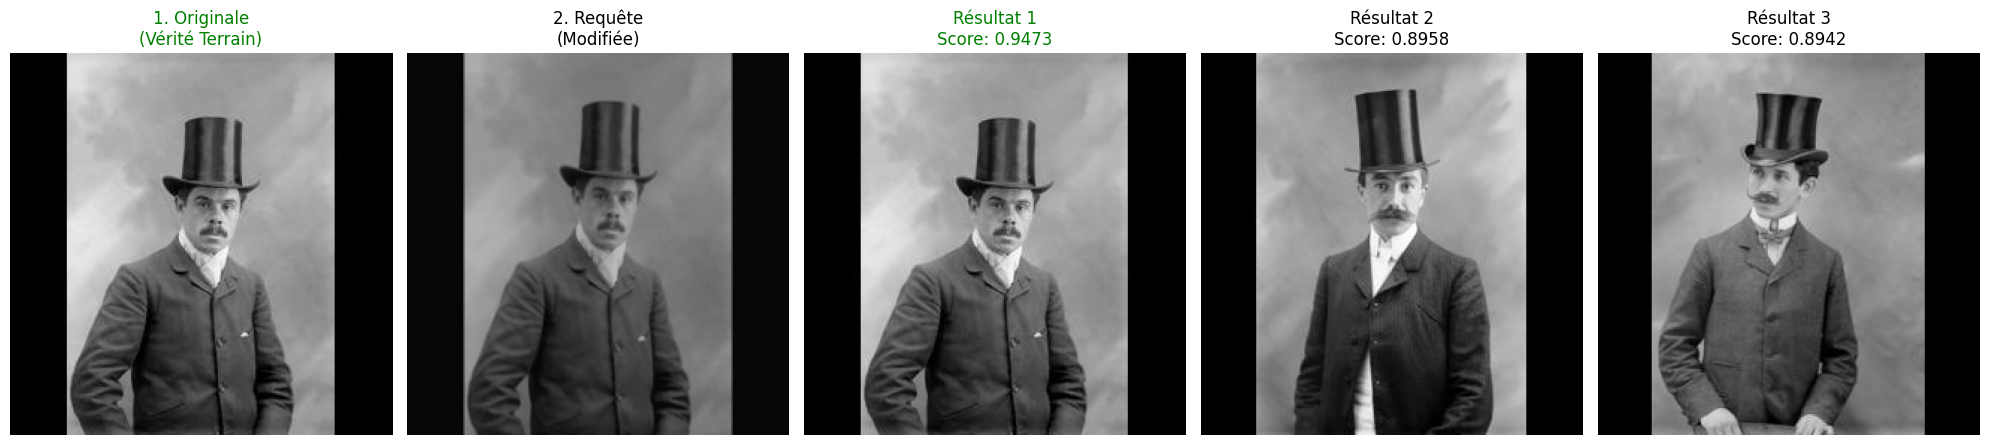

In [13]:
import torchvision.transforms as T

def test_near_duplicate(idx_image=0):
    # 1. Sélection de l'image originale dans la base
    original_path = df_final.iloc[idx_image]['full_path']
    original_img = Image.open(original_path).convert('RGB')

    # 2. Création d'un "Near-Duplicate"
    transform = T.Compose([
        T.ColorJitter(brightness=0.2, contrast=0.2),
        T.RandomResizedCrop(size=(224, 224), scale=(0.9, 1.0)),
        T.RandomGrayscale(p=0.2),
    ])
    modified_img = transform(original_img)

    # 3. Encodage de l'image modifiée (Pixels)
    modified_embedding = model.encode(modified_img, convert_to_tensor=True)

    # 4. Calcul de la similarité cosinus avec l'index de PIXELS
    cos_scores = util.cos_sim(modified_embedding, embeddings)[0]

    # 5. Récupération des 3 meilleurs résultats
    top_results = torch.topk(cos_scores, k=3)

    # --- AFFICHAGE ---
    plt.figure(figsize=(20, 6))

    plt.subplot(1, 5, 1)
    plt.imshow(original_img)
    plt.title("1. Originale\n(Vérité Terrain)", color='green')
    plt.axis('off')

    plt.subplot(1, 5, 2)
    plt.imshow(modified_img)
    plt.title("2. Requête\n(Modifiée)")
    plt.axis('off')

    for i in range(3):
        idx = int(top_results.indices[i])
        score = float(top_results.values[i])
        res_path = df_final.iloc[idx]['full_path']

        plt.subplot(1, 5, i+3)
        plt.imshow(Image.open(res_path))

        color = 'green' if idx == idx_image else 'black'
        plt.title(f"Résultat {i+1}\nScore: {score:.4f}", color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Lancer le test
test_near_duplicate(51)

**Observation sur l'exemple :** Le modèle identifie avec succès l'image originale (Score > 0.94) malgré les transformations.

**3.2. Évaluation Quantitative (Recall@1)**

Pour valider ton approche "Inférence seule", il est crucial de calculer le score sur un échantillon aléatoire.

In [16]:
def calculate_recall_zero_shot(n_tests=50):
    correct = 0
    test_indices = np.random.choice(len(df_final), n_tests, replace=False)

    for idx in tqdm(test_indices):
        path = df_final.iloc[idx]['full_path']
        img = Image.open(path).convert('RGB')

        # Création du doublon
        query_img = T.Compose([T.ColorJitter(0.2, 0.2), T.RandomResizedCrop(224, scale=(0.9, 1.0))])(img)
        query_emb = model.encode(query_img, convert_to_tensor=True, show_progress_bar=False)

        # Recherche
        scores = util.cos_sim(query_emb, embeddings)[0]
        if int(torch.argmax(scores)) == idx:
            correct += 1

    recall = (correct / n_tests) * 100
    print(f"\nRecall@1 (Inférence seule) : {recall}%")
    return recall

calculate_recall_zero_shot(100)

100%|██████████| 100/100 [00:23<00:00,  4.34it/s]


Recall@1 (Inférence seule) : 99.0%


99.0

Pour valider scientifiquement la performance, nous automatisons le test sur un échantillon aléatoire de 100 images.

* Métrique utilisée : Le Recall@1 (capacité du système à trouver l'image exacte en première position).

* Résultat obtenu : 99.0%. Cela prouve que même sans fine-tuning, CLIP est extrêmement performant pour retrouver des quasi-doublons dans des fonds photographiques historiques.